In [1]:
from IPython.display import Image
#Image(filename='ANTI-INFECTIVES-RGB_200pc.png')

In [2]:
#%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig, ax = plt.subplots(figsize=(18, 10))
img=mpimg.imread('ANTI-INFECTIVES-RGB_200pc.png')
imgplot = ax.imshow(img)
plt.axis('off')
plt.grid(b=None)
plt.show()

<Figure size 1800x1000 with 1 Axes>


# Analysis of Senescent Proteins in Human

Michele Tinti and Michael A.J. Ferguson

Wellcome Centre for Anti-Infectives Research
School of Life Sciences, University of Dundee


## Aims
We are analysing normal versus oncogene-induced senescent cells to identify putative drug targets. We are particularly interested in transmembrane protein and protein with signal peptides that are likely to be transported on the cell plasma membrane.

In [3]:
%matplotlib inline

In [4]:
import sys
print(sys.version)

3.7.1 | packaged by conda-forge | (default, Mar 13 2019, 13:32:59) [MSC v.1900 64 bit (AMD64)]


In [5]:
#iteresting ref for tmt/ibaq data normalization
#https://pwilmart.github.io/IRS_normalization/understanding_IRS.html

#import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import os
from tqdm import tqdm
from tqdm import tqdm_notebook
import missingno as msno
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

In [6]:
#define helping function
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from adjustText import adjust_text

def make_scatter_matrix(in_df):
    sns.set(font_scale = 1)
    #sns.set(style="white")
    def corrfunc(x, y, **kws):
        r, _ = stats.pearsonr(x, y)
        ax = plt.gca()
        ax.annotate("r = {:.3f}".format(r),
                    xy=(.1, .9), xycoords=ax.transAxes)
    
    g = sns.PairGrid(in_df, palette=["red"]) 
    g.map_upper(plt.scatter, s=10)
    g.map_diag(sns.distplot, kde=False) 
    g.map_lower(sns.kdeplot, cmap="Blues_d") 
    g.map_lower(corrfunc)
    plt.show()


def make_pca(in_df, palette, top=500):
    cols = in_df.columns
    pca = PCA(n_components=2)
    
    sorted_mean = in_df.mean(axis=1).sort_values()
    select = sorted_mean.tail(top)
    #print(top)
    in_df = in_df.loc[select.index.values]
    pca.fit(in_df)
    temp_df = pd.DataFrame()
    temp_df['pc_1']=pca.components_[0]
    temp_df['pc_2']=pca.components_[1]
    temp_df.index = cols
    print(pca.explained_variance_ratio_)
    temp_df['color']=palette
    fig,ax=plt.subplots(figsize=(12,6))
    temp_df.plot(kind='scatter',x='pc_1',y='pc_2',s=30, c=temp_df['color'], ax=ax)
    #print(temp_df.index.values)
       
    texts = [plt.text(temp_df.iloc[i]['pc_1'], 
                       temp_df.iloc[i]['pc_2'],
                       cols[i])
                       for i in range(temp_df.shape[0])]
    
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))
    ax.set_title('PCA',size=14)
    ax.set_xlabel('PC1_{:.3f}'.format(pca.explained_variance_ratio_[0]),size=12)
    ax.set_ylabel('PC2_{:.3f}'.format(pca.explained_variance_ratio_[1]),size=12)
    
    ax.yaxis.label.set_size(12)
    ax.xaxis.label.set_size(12)
    plt.show()
    
def make_mds(in_df, palette, top=500):
    cols = in_df.columns
    pca = MDS(n_components=2,metric=True)
    
    sorted_mean = in_df.mean(axis=1).sort_values()
    select = sorted_mean.tail(top)
    #print(top)
    in_df = in_df.loc[select.index.values]
    temp_df = pd.DataFrame(pca.fit_transform(in_df.T),
                                 index=cols,columns =['pc_1','pc_2'] )
    
    temp_df['color']=palette
    fig,ax=plt.subplots(figsize=(12,6))
    temp_df.plot(kind='scatter',x='pc_1',y='pc_2',s=50, c=temp_df['color'], ax=ax)
    #print(temp_df.index.values)
       
    texts = [plt.text(temp_df.iloc[i]['pc_1'], 
                       temp_df.iloc[i]['pc_2'],
                       cols[i])
                       for i in range(temp_df.shape[0])]
    
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))
    ax.set_title('MDS',size=14)
    ax.set_xlabel('DIM_1',size=12)
    ax.set_ylabel('DIM_2',size=12)
    
    ax.yaxis.label.set_size(12)
    ax.xaxis.label.set_size(12)

    plt.show()


In [7]:
path='D:\\michele\\old_age\\raw\\combined\\txt\\evidence.txt'
evi = pd.read_table(path)
temp = evi[['Reporter intensity corrected {}'.format(n) for n in range(1,7)]]
evi['na_count']=temp.replace(0,np.nan).isnull().sum(axis=1)
evi['all_na']=[1 if n ==6 else 0 for n in evi['na_count']]
print(evi['all_na'].value_counts())
evi['na_count'].value_counts()/evi['na_count'].value_counts().sum()

0    86281
1     2616
Name: all_na, dtype: int64


0    0.956489
6    0.029427
1    0.006862
2    0.003352
3    0.002036
4    0.001125
5    0.000709
Name: na_count, dtype: float64

## Dataset analysis

In [7]:
#load the datasetD:\michele\old_age\raw\combined\txt
df = pd.read_table(os.path.join('raw', 'combined', 'txt', 'proteinGroups.txt'))
df.head()
#print(df.columns)
df = df[df['Only identified by site']!='+']
df = df[df['Potential contaminant']!='+']
df = df[df['Reverse']!='+']
#print(list(df.columns))
cols = ['Reporter intensity corrected {}'.format(n) for n in range(1,7)]
data=df[cols]
data.columns = ['S1','S2','S3', 'C1','C2','C3']

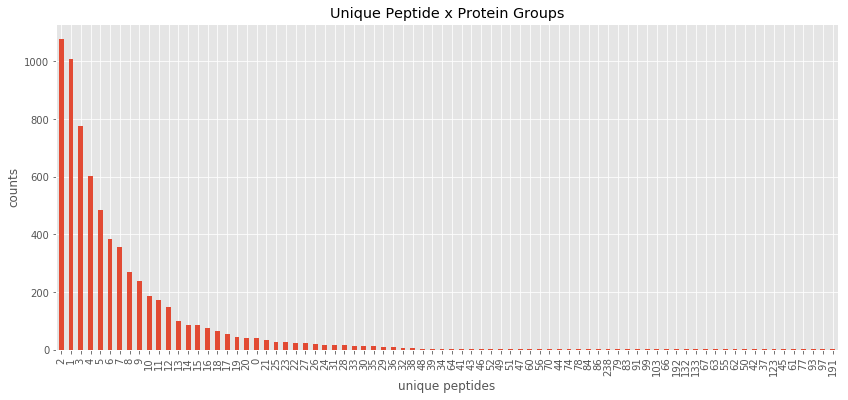

In [9]:
fig,ax=plt.subplots(figsize=(14,6))
df['Unique peptides'].value_counts().plot(kind='bar',ax=ax)
plt.title('Unique Peptide x Protein Groups')
ax.set_xlabel('unique peptides')
ax.set_ylabel('counts')
plt.show()

We can see many protein groups identified with just one unique peptide, not good.

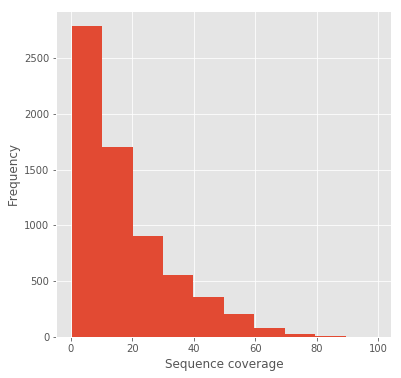

In [10]:
fig,ax=plt.subplots(figsize=(6,6))
df['Sequence coverage [%]'].plot(kind='hist',ax=ax)
ax.set_xlabel('Sequence coverage')
plt.show()

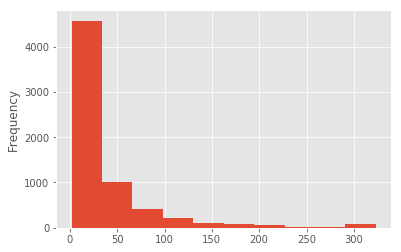

In [11]:
df['Score'].plot(kind='hist')
ax.set_xlabel('Score')
plt.show()

### Missing Data Analysis

(6617, 6)


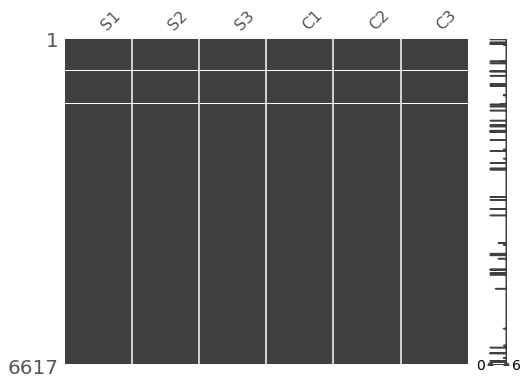

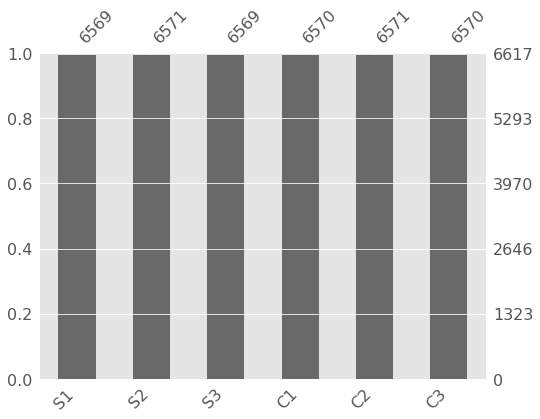

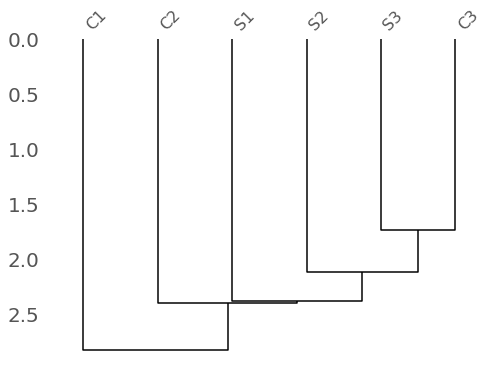

(6617, 6)


In [8]:
print(data.shape)
data=data.replace(0, np.nan)
msno.matrix(data, figsize=(8, 6))
#plt.title('Missing Data')
plt.show()

msno.bar(data, figsize=(8, 6))
plt.show()

msno.dendrogram(data, figsize=(8, 6))
plt.show()

data=data.replace(np.nan,0)
data = data.dropna(how='all')
print(data.shape)

This picture show that we identified an 6614 protein groups. For the moment we do not use any filter for the number of unique peptides

In [9]:
#how many protein group with two unique peptides?
df[df['Unique peptides']>=2].shape

(5569, 96)

### Average Intensity

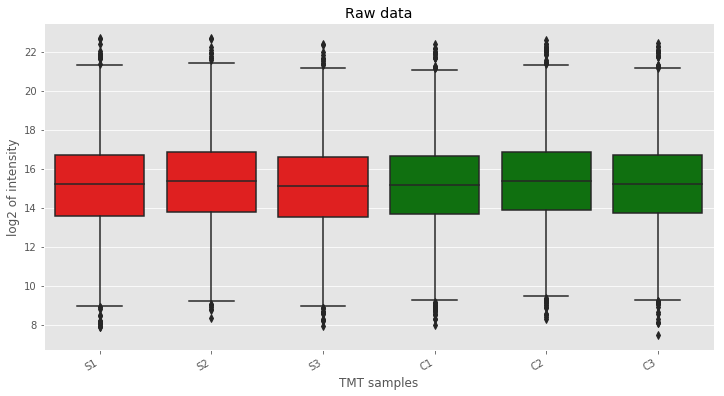

In [11]:
my_pal = ["r"]*3+["g"]*3
fig,ax=plt.subplots(figsize=(12,6))
g = sns.boxplot(data=np.log2(data),ax=ax,palette=my_pal)
g.set_xticklabels(data.columns, rotation=30, ha='right')
plt.title('Raw data')
plt.xlabel('TMT samples')
plt.ylabel('log2 of intensity')
plt.show()

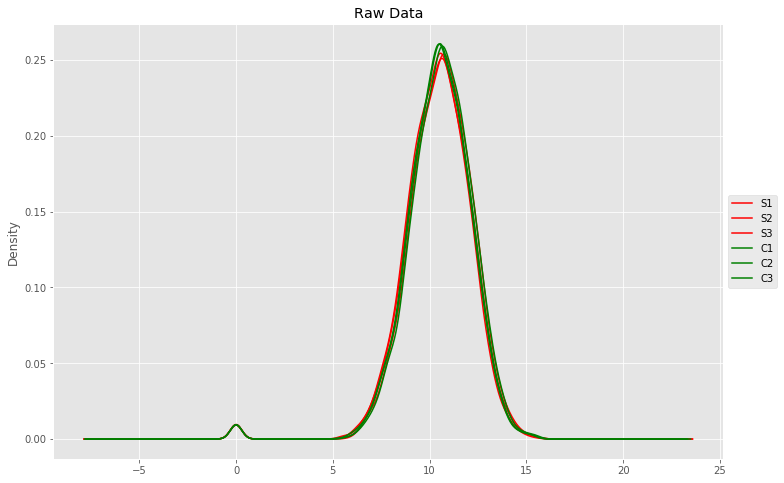

In [12]:
fig,ax=plt.subplots(figsize=(12,8))
np.log1p(data).plot(kind='kde',ax=ax,color=my_pal)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Raw Data')
plt.show()

Tee pictures above show a very good distribution of the TMT channel intensity for bot senescent (S1,S2,S3) and control (C1 C2 C3) cells.

### PCA analysis


[0.94833333 0.04745283]


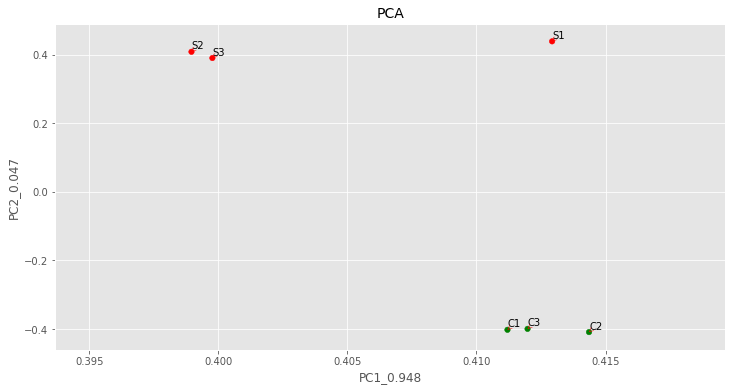

In [13]:
make_pca(np.log2(data), my_pal)

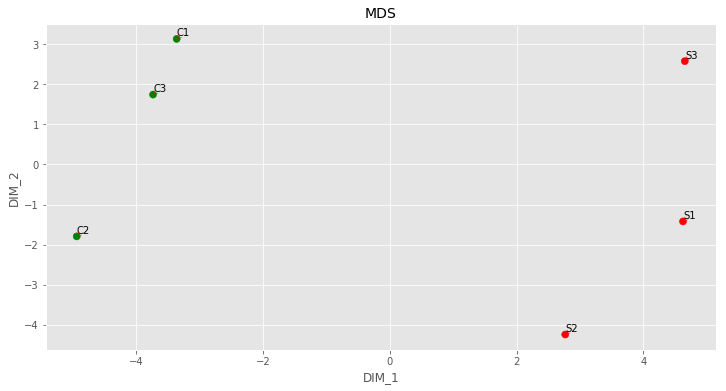

In [14]:
make_mds(np.log2(data), my_pal)

With two dimensinality reduction tecniques (PCA and MDS) we observe a good separation of senescent (S1,S2,S3) and control (C1 C2 C3) cells.

### Reproducibility analysis

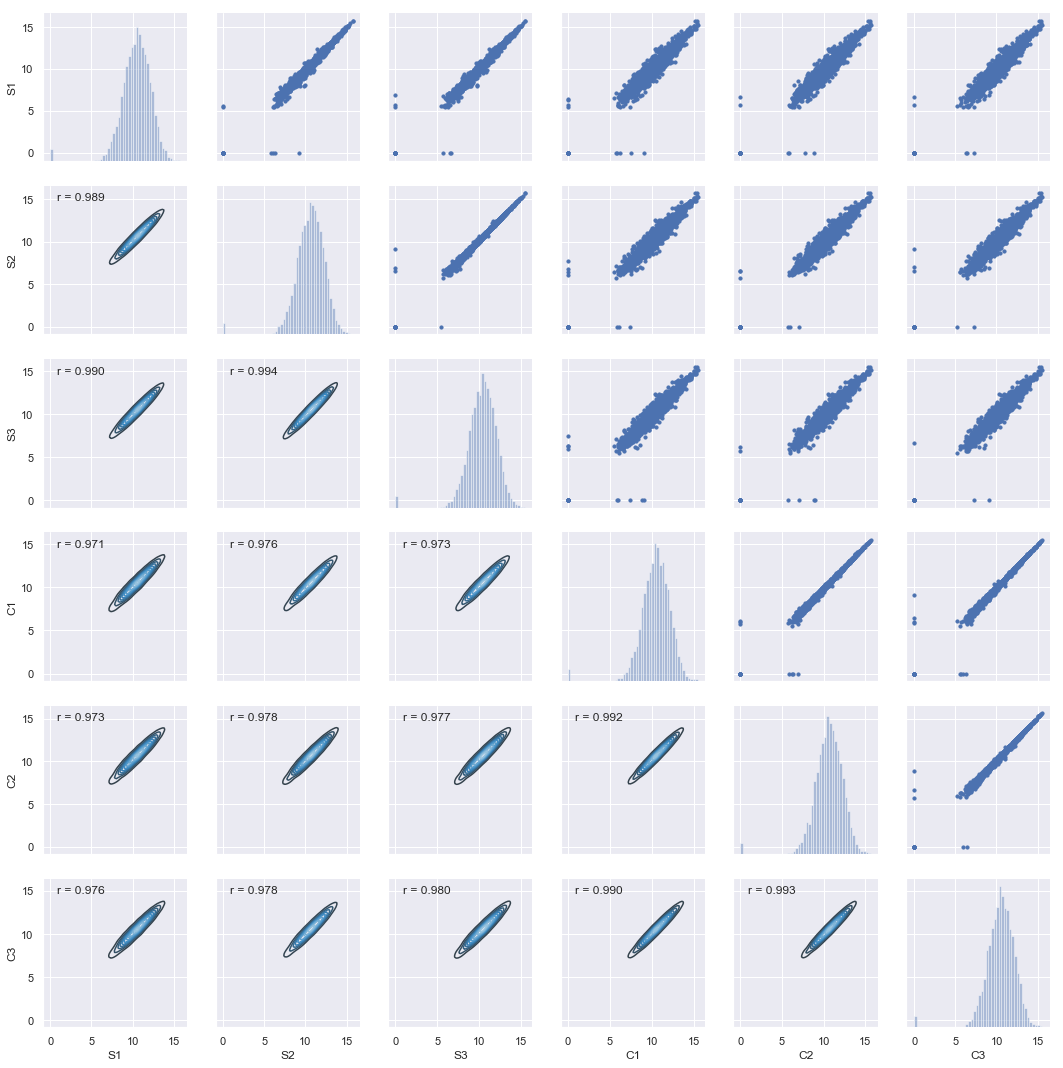

In [18]:
make_scatter_matrix(np.log1p(data))

The figure above show a very good intraclass correlation  between the senescent samples (S1,S2,S3) and the control samples (C1 C2 C3). As expected, the correletion decrese between samples of different classes.

### Data Normalization
We do a correction for sample loading artefact. We do not expect the signal to change much.

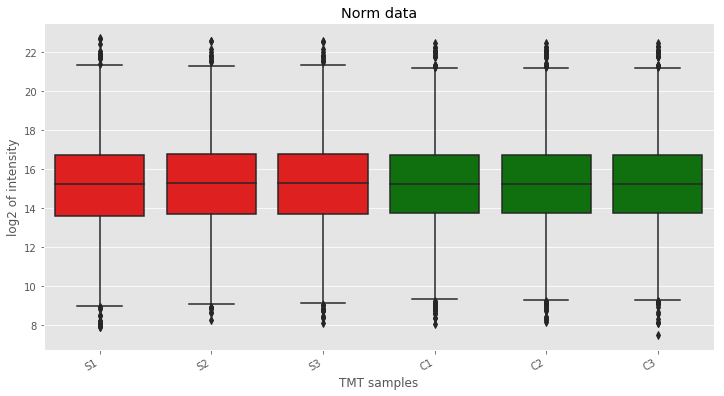

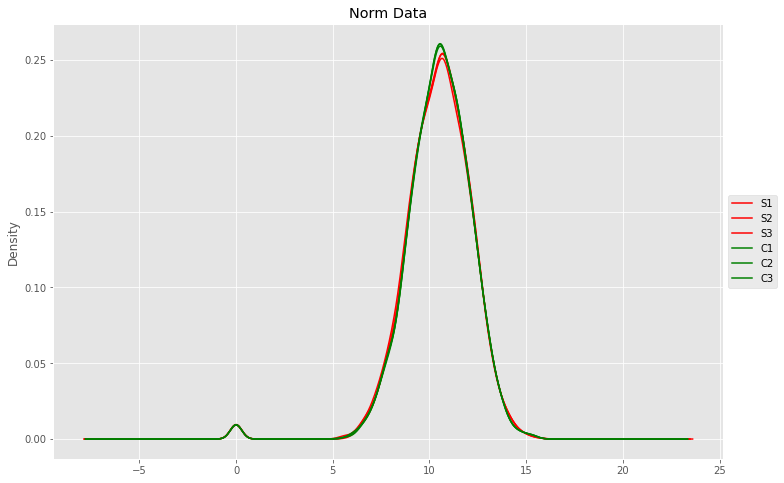

In [15]:
#normalization
#we create normalization factors based on the average sum intensity of each channel
col_sum = data.sum(axis=0)
target = np.mean(col_sum)
norm_facs = target / col_sum
data_norm = data.multiply(norm_facs, axis=1)


fig,ax=plt.subplots(figsize=(12,6))
g = sns.boxplot(data=np.log2(data_norm),ax=ax,palette=my_pal)
g.set_xticklabels(data.columns, rotation=30, ha='right')
plt.title('Norm data')
plt.xlabel('TMT samples')
plt.ylabel('log2 of intensity')
plt.show()
fig,ax=plt.subplots(figsize=(12,8))
np.log1p(data_norm).plot(kind='kde',ax=ax,color=my_pal)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Norm Data')
plt.show()

In [16]:
data_norm['genes'] = data_norm.index.map(df['Gene names'])
data_norm['genes']=[str(n).split(';')[0] for n in data_norm['genes']]
data_norm['genes']=[str(n[0])+'_'+str(n[1]) for n in zip(data_norm.index.values,data_norm['genes'])]
data_norm.to_csv('norm_data_maxquant16660.csv',sep='\t',index=False)

In [17]:
data_norm.head(6)

,S1,S2,S3,C1,C2,C3,genes
0,7731.402778,7710.125388,7687.881790,11465.012091,11164.829946,11064.741989,0_CLN3
1,12681.056637,16100.643273,16321.488397,17846.909779,17770.725286,18109.811290,1_SLC35B3
2,434328.715939,387491.597935,400318.723231,387711.644942,382583.913974,402362.546681,2_SERPINB6
3,63476.014180,56020.590264,61900.357394,52998.600920,53192.988025,50701.998533,3_hCG_2014768
4,49232.813036,42269.870898,47982.418082,37551.639750,42302.651270,39603.809949,4_HDGFRP3
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5_THOC7


### Testing for differences.
We use limma package in R to identify protein with a differential expression between normal and senescent cells.

In [1]:
options(warn=-1)
library("tidyverse")
library("psych")
library("gridExtra")
library("scales")
library("limma") 
library("edgeR") 
limma_data <- read_tsv("norm_data_maxquant16660.csv")
accession <- limma_data$'genes'
limma_data = within(limma_data, rm('genes'))
head(limma_data)

-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.1.1       v purrr   0.3.2  
v tibble  2.1.1       v dplyr   0.8.0.1
v tidyr   0.8.3       v stringr 1.4.0  
v readr   1.3.1       v forcats 0.4.0  
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Attaching package: 'psych'

The following objects are masked from 'package:ggplot2':

    %+%, alpha


Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

    combine


Attaching package: 'scales'

The following objects are masked from 'package:psych':

    alpha, rescale

The following object is masked from 'package:purrr':

    discard

The following object is masked from 'package:readr':

    col_factor

Parsed with column specification:
cols(
  S1 = col_double(),
  S2 = col_double(),
  S3 = col_double(),
  C1 = col_double(),
  C2 = col_double(),
  C3 = col

S1,S2,S3,C1,C2,C3
7731.403,7710.125,7687.882,11465.01,11164.83,11064.74
12681.057,16100.643,16321.488,17846.91,17770.73,18109.81
434328.716,387491.598,400318.723,387711.64,382583.91,402362.55
63476.014,56020.590,61900.357,52998.60,53192.99,50702.00
49232.813,42269.871,47982.418,37551.64,42302.65,39603.81
0.000,0.000,0.000,0.00,0.00,0.00


In [2]:
row.names(limma_data) <- accession # add accessions as row names
# set up the design matrix
group <- as.factor(c(rep("senescent", 3), rep("control", 3)))
group <- factor(group, levels(group)[c(2, 1)]) # set the factor order
design <- model.matrix(~ 0 + group)
colnames(design) <- c("senescent", "control")
design
# make the contrast
contrast <- makeContrasts(senescent-control, levels = design)
contrast


senescent,control
1,0
1,0
1,0
0,1
0,1
0,1


,senescent - control
senescent,1
control,-1


In [3]:
S <- 1:3
C <- 4:6
# do the linear model fitting on log2 values
limma_log_data <- log2(limma_data[c(S, C)])
fit <- lmFit(limma_log_data, design)

# get the fit for the contrast of interest
fit2 <- contrasts.fit(fit, contrast)

# do the empirical Bayes moderation of the test statistic (with trended variance)
fit2 <- eBayes(fit2, trend = TRUE)

# grab the information in topTable so we can get the data to plot candidates
# the coef parameter has to do with the contrast of interest
# specify no sorting of results and a number that is longer than the data table
tt_limma <- topTable(fit2, coef = 1, sort.by = "none", number = Inf)

# let's see how many up and down candidates, and the top tags
summary(decideTests(fit2, p.value = 0.10))
topTable(fit2)


       senescent - control
Down                  2009
NotSig                2388
Up                    2176

,logFC,AveExpr,t,P.Value,adj.P.Val,B
3451,3.037568,16.51146,71.02864,7.089421e-12,3.409904e-08,17.60298
2650,2.236167,16.90444,65.78759,1.258149e-11,3.409904e-08,17.17973
3980,-2.726362,17.06762,-63.94390,1.556323e-11,3.409904e-08,17.01714
3277,1.599947,19.26762,60.86535,2.251217e-11,3.699313e-08,16.72792
1226,1.532955,17.46340,52.65582,6.652642e-11,7.490510e-08,15.83058
3978,-1.546584,17.72148,-52.46311,6.837526e-11,7.490510e-08,15.80699
3021,1.379801,20.32515,49.95163,9.866224e-11,9.264384e-08,15.48760
4023,-1.979718,15.14637,-44.32468,2.409654e-10,1.557837e-07,14.68119
4385,1.298836,17.91753,43.58791,2.730996e-10,1.557837e-07,14.56513
2641,-1.575460,17.77565,-43.18108,2.929095e-10,1.557837e-07,14.49990


In [4]:
limma_data$ave_med <- rowMeans(limma_data[S])
limma_data$ave_exo  <- rowMeans(limma_data[C])
limma_data$logFC <- log2(limma_data$ave_exo / limma_data$ave_med)
limma_data$FC <- ifelse(limma_data$ave_exo > limma_data$ave_med, 
                          (limma_data$ave_exo / limma_data$ave_med), 
                          (-1 * limma_data$ave_med / limma_data$ave_exo))
limma_data$Acc <- accession
head(limma_data)

S1,S2,S3,C1,C2,C3,ave_med,ave_exo,logFC,FC,Acc
7731.403,7710.125,7687.882,11465.01,11164.83,11064.74,7709.803,11231.53,0.54278825,1.456785,0_CLN3
12681.057,16100.643,16321.488,17846.91,17770.73,18109.81,15034.396,17909.15,0.25242985,1.191212,1_SLC35B3
434328.716,387491.598,400318.723,387711.64,382583.91,402362.55,407379.679,390886.04,-0.05962597,-1.042196,2_SERPINB6
63476.014,56020.590,61900.357,52998.60,53192.99,50702.00,60465.654,52297.86,-0.20936390,-1.156178,3_hCG_2014768
49232.813,42269.871,47982.418,37551.64,42302.65,39603.81,46495.034,39819.37,-0.22360635,-1.167649,4_HDGFRP3
0.000,0.000,0.000,0.00,0.00,0.00,0.000,0.00,NaN,NaN,5_THOC7


In [5]:
# statisticl test results
limma_data$PValue <- tt_limma$P.Value
limma_data$FDR <- tt_limma$adj.P.Val
head(limma_data)
# add a DE candidate status column
limma_data$candidate <- cut(limma_data$FDR, breaks = c(-Inf, 0.01, 0.05, 0.10, 1.0), 
                           labels = c("high", "med", "low", "no"))

S1,S2,S3,C1,C2,C3,ave_med,ave_exo,logFC,FC,Acc,PValue,FDR
7731.403,7710.125,7687.882,11465.01,11164.83,11064.74,7709.803,11231.53,0.54278825,1.456785,0_CLN3,3.587118e-05,0.0002238677
12681.057,16100.643,16321.488,17846.91,17770.73,18109.81,15034.396,17909.15,0.25242985,1.191212,1_SLC35B3,3.293473e-02,0.0569085054
434328.716,387491.598,400318.723,387711.64,382583.91,402362.55,407379.679,390886.04,-0.05962597,-1.042196,2_SERPINB6,2.407366e-01,0.3099631693
63476.014,56020.590,61900.357,52998.60,53192.99,50702.00,60465.654,52297.86,-0.20936390,-1.156178,3_hCG_2014768,6.497816e-03,0.0144976720
49232.813,42269.871,47982.418,37551.64,42302.65,39603.81,46495.034,39819.37,-0.22360635,-1.167649,4_HDGFRP3,1.632773e-02,0.0313624067
0.000,0.000,0.000,0.00,0.00,0.00,0.000,0.00,NaN,NaN,5_THOC7,NA,NA


In [6]:
# add a DE candidate status column
limma_data$candidate <- cut(limma_data$FDR, breaks = c(-Inf, 0.01, 0.05, 0.10, 1.0), 
                           labels = c("high", "med", "low", "no"))


In [7]:
# count candidates
print("Candidate Counts:")
summary(limma_data$candidate)

[1] "Candidate Counts:"


high  med  low   no NA's 
2745  991  449 2388   44

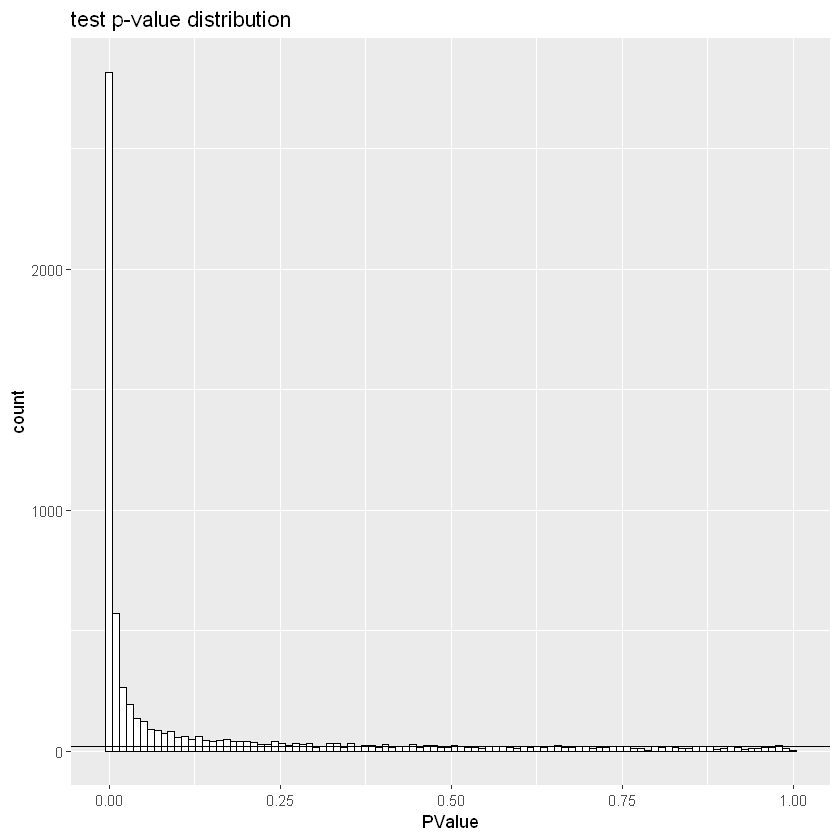

In [8]:
pvalue_plot <- function(results, title) {
    # Makes p-value distribution plots
        # results - results data frame
        # title - plot title
    ggplot(results, aes(PValue)) + 
        geom_histogram(bins = 100, fill = "white", color = "black") +
        geom_hline(yintercept = mean(hist(results$PValue, breaks = 100, 
                                     plot = FALSE)$counts[26:100])) +
        ggtitle(str_c(title, " p-value distribution"))
}

pvalue_plot(limma_data, "test")

The figure above show the expected distribution of p-value, our test is safe

In [11]:
head(limma_data)

S1,S2,S3,C1,C2,C3,ave_med,ave_exo,logFC,FC,Acc,PValue,FDR,candidate
7731.403,7710.125,7687.882,11465.01,11164.83,11064.74,7709.803,11231.53,0.54278825,1.456785,0_CLN3,3.587118e-05,0.0002238677,high
12681.057,16100.643,16321.488,17846.91,17770.73,18109.81,15034.396,17909.15,0.25242985,1.191212,1_SLC35B3,3.293473e-02,0.0569085054,low
434328.716,387491.598,400318.723,387711.64,382583.91,402362.55,407379.679,390886.04,-0.05962597,-1.042196,2_SERPINB6,2.407366e-01,0.3099631693,no
63476.014,56020.590,61900.357,52998.60,53192.99,50702.00,60465.654,52297.86,-0.20936390,-1.156178,3_hCG_2014768,6.497816e-03,0.0144976720,med
49232.813,42269.871,47982.418,37551.64,42302.65,39603.81,46495.034,39819.37,-0.22360635,-1.167649,4_HDGFRP3,1.632773e-02,0.0313624067,med
0.000,0.000,0.000,0.00,0.00,0.00,0.000,0.00,NaN,NaN,5_THOC7,NA,NA,NA


In [12]:
write.table(limma_data,'limma_data_maxquant16660.txt')
#data_norm = pd.read_csv('norm_data.csv',sep='\t')
#print(data_norm.shape)
#data_norm.head()
#del data_norm['gene_names']

In [19]:
data_norm.head()

,S1,S2,S3,C1,C2,C3,genes
0,7731.402778,7710.125388,7687.881790,11465.012091,11164.829946,11064.741989,0_CLN3
1,12681.056637,16100.643273,16321.488397,17846.909779,17770.725286,18109.811290,1_SLC35B3
2,434328.715939,387491.597935,400318.723231,387711.644942,382583.913974,402362.546681,2_SERPINB6
3,63476.014180,56020.590264,61900.357394,52998.600920,53192.988025,50701.998533,3_hCG_2014768
4,49232.813036,42269.870898,47982.418082,37551.639750,42302.651270,39603.809949,4_HDGFRP3


In [18]:
#we load back the R analysis
r_analysis = pd.read_table('limma_data_maxquant16660.txt',sep=' ')
print(r_analysis.shape)
r_analysis = r_analysis.reset_index(drop=True)
r_analysis.head()

(6617, 14)


,S1,S2,S3,C1,C2,C3,ave_med,ave_exo,logFC,FC,Acc,PValue,FDR,candidate
0,7731.402778,7710.125388,7687.881790,11465.012091,11164.829946,11064.741989,7709.803319,11231.528009,0.542788,1.456785,0_CLN3,0.000036,0.000224,high
1,12681.056637,16100.643273,16321.488397,17846.909779,17770.725286,18109.811290,15034.396102,17909.148785,0.252430,1.191212,1_SLC35B3,0.032935,0.056909,low
2,434328.715939,387491.597935,400318.723231,387711.644942,382583.913974,402362.546681,407379.679035,390886.035199,-0.059626,-1.042196,2_SERPINB6,0.240737,0.309963,no
3,63476.014180,56020.590264,61900.357394,52998.600920,53192.988025,50701.998533,60465.653946,52297.862493,-0.209364,-1.156178,3_hCG_2014768,0.006498,0.014498,med
4,49232.813036,42269.870898,47982.418082,37551.639750,42302.651270,39603.809949,46495.034005,39819.366990,-0.223606,-1.167649,4_HDGFRP3,0.016328,0.031362,med


In [20]:
data_def = data_norm.merge(r_analysis.iloc[:,6:],left_on='genes',right_on='Acc' )
data_def.shape

(6617, 15)

In [21]:
#top 50 proteins
data_def.sort_values('FDR').head(10)

,S1,S2,S3,C1,C2,C3,genes,ave_med,ave_exo,logFC,FC,Acc,PValue,FDR,candidate
3979,5.441739e+04,5.044683e+04,5.545651e+04,353165.489052,348073.618744,358942.784219,4087_NCOA4,5.344025e+04,353393.964005,2.725279,6.612881,4087_NCOA4,1.556323e-11,3.409904e-08,high
3450,2.550863e+05,2.771482e+05,2.713522e+05,33460.842275,32336.020220,32026.635715,3555_STC1,2.678622e+05,32607.832737,-3.038201,-8.214658,3555_STC1,7.089421e-12,3.409904e-08,high
2649,2.739613e+05,2.629633e+05,2.620474e+05,55505.284364,57003.386923,57051.784057,2747_MMP1,2.663240e+05,56520.151781,-2.236345,-4.712018,2747_MMP1,1.258149e-11,3.409904e-08,high
3276,1.113306e+06,1.107516e+06,1.076171e+06,362570.835868,357581.557226,367436.192469,3380_NAMPT,1.098998e+06,362529.528521,-1.600018,-3.031471,3380_NAMPT,2.251217e-11,3.699313e-08,high
3977,1.249210e+05,1.282021e+05,1.262424e+05,375505.829692,370827.659555,361952.977835,4085_ALCAM,1.264552e+05,369428.822361,1.546670,2.921421,4085_ALCAM,6.837526e-11,7.490510e-08,high
1225,3.120550e+05,3.021039e+05,3.082014e+05,106523.478549,106980.109338,105214.881914,1302_PLAU,3.074534e+05,106239.489934,-1.533048,-2.893966,1302_PLAU,6.652642e-11,7.490510e-08,high
3020,2.091920e+06,2.170131e+06,2.096267e+06,794128.305463,822829.456767,826404.568597,3123_TNC,2.119439e+06,814454.110276,-1.379777,-2.602282,3123_TNC,9.866224e-11,9.264384e-08,high
4022,1.867702e+04,1.780209e+04,1.831585e+04,70732.435181,74067.111655,71322.331570,4130_FZD2,1.826499e+04,72040.626135,1.979730,3.944192,4130_FZD2,2.409654e-10,1.557837e-07,high
4384,3.855041e+05,3.930672e+05,3.864849e+05,154321.662426,161653.012954,157634.819228,4493_WLS,3.883521e+05,157869.831536,-1.298630,-2.459951,4493_WLS,2.730996e-10,1.557837e-07,high
772,1.041261e+05,1.028382e+05,9.879887e+04,25585.713682,24228.538773,23218.018639,784_NAP1L6,1.019211e+05,24344.090365,-2.065809,-4.186686,784_NAP1L6,3.792087e-10,1.557837e-07,high


The top 20 protein by FDR are all under represented in senescent cell

## Visualize differential expression

In [22]:
data_def['log10p']=-np.log10(data_def['PValue'])

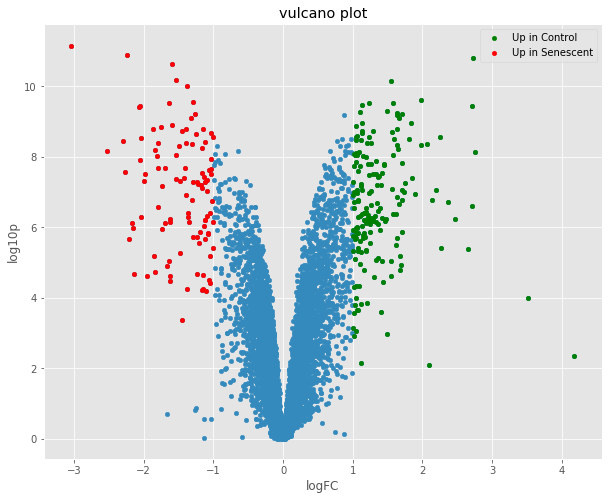

In [23]:
fig,ax=plt.subplots(figsize=(10,8))

data_def.plot(kind='scatter',x='logFC',y='log10p',ax=ax)

data_def[(data_def['PValue']<0.05) & (data_def['logFC']>1)].plot(
    kind='scatter',x='logFC',y='log10p',ax=ax, c='g', label='Up in Control')

data_def[(data_def['PValue']<0.05) & (data_def['logFC']<-1)].plot(
    kind='scatter',x='logFC',y='log10p',ax=ax, c='r', label='Up in Senescent')
plt.legend()
plt.title('vulcano plot')
plt.show()

## Interactive Vulcano Plot


In [24]:
up_control = data_def[(data_def['PValue']<0.05) & (data_def['logFC']>1)]
up_senescent = data_def[(data_def['PValue']<0.05) & (data_def['logFC']<-1)]
the_rest = data_def.iloc[~data_def.index.isin( list(up_control.index.values) + list(up_senescent.index.values) ) ]
#the_rest = the_rest.iloc[~up_senescent.index.values]


In [25]:
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
#interactive plot 'logFC',y='log10p'
trace_1 = go.Scatter(
    x=the_rest.logFC,
    y=the_rest.log10p,
    mode='markers',
    name='MA Plot',
    #text = [a + ' ' +b for a,b in zip(temp.index.values, temp.Gene_desc)],
    #hoverinfo = 'text',
    marker=dict(
        #size=16,
        color = 'blue'#np.log10(temp.Score), #set color equal to a variable
        #colorscale='Bluered',
        #showscale=True
    )
)

trace_2 = go.Scatter(
    x=up_control.logFC,
    y=up_control.log10p,
    mode='markers',
    name='MA Plot',
    text = up_control.genes,
    hoverinfo = 'text',
    marker=dict(
        #size=16,
        color = 'green'#np.log10(temp.Score), #set color equal to a variable
        #colorscale='Bluered',
        #showscale=True
    )
)

trace_3 = go.Scatter(
    x=up_senescent.logFC,
    y=up_senescent.log10p,
    mode='markers',
    name='MA Plot',
    text = up_control.genes,
    hoverinfo = 'text',
    marker=dict(
        #size=16,
        color = 'red'#np.log10(temp.Score), #set color equal to a variable
        #colorscale='Bluered',
        #showscale=True
    )
)

'''

annot_1 = go.Scatter(
    x=[temp.signal_perc.loc['Tb927.3.2610']],
    y=[temp.signal_logfc.loc['Tb927.3.2610']],
    mode='markers+text',
    name='Tb927.3.2610',
    text=['Bait'],
    textposition='bottom center'
)
'''

layout = dict(title='Vulcano',
             width=1000,
             height=800)


fig = go.Figure(data=[trace_1,trace_2,trace_3], 
                layout=layout)
iplot(fig, filename='test')

In [26]:
#attach the old index so we can grab other columns from the MaxQuont ProteinGroup file
data_def['index']=[int(n.split('_')[0]) for n in data_def['genes']]
data_def.head()
data_def.set_index('index',inplace=True,drop=True)

In [27]:
#write proteins for go enrichemnt analysis
#data_def[data_def['logFC']<-1].sort_values('PValue').to_csv('up_senescent.csv')

### Visualize some top candidates


In [28]:
def plot_prot(prot_id = 2742, data_def='', df=''):
    fig,ax = plt.subplots(figsize=(8,8))
    temp = data_def.loc[prot_id][['S1','S2','S3','C1','C2','C3']]
    #print(temp)#
    #print(temp)
    print(df.loc[prot_id]['Protein names'])
    temp.plot(kind='bar', ax=ax, colors=my_pal)
    ax.set_xlabel('Sample')
    ax.set_ylabel('TMT intensity')
    plt.show()
data_def[data_def['logFC']<-1].sort_values('PValue').head()

,S1,S2,S3,C1,C2,C3,genes,ave_med,ave_exo,logFC,FC,Acc,PValue,FDR,candidate,log10p
index,,,,,,,,,,,,,,,,
3555,2.550863e+05,2.771482e+05,2.713522e+05,33460.842275,32336.020220,32026.635715,3555_STC1,2.678622e+05,32607.832737,-3.038201,-8.214658,3555_STC1,7.089421e-12,3.409904e-08,high,11.149389
2747,2.739613e+05,2.629633e+05,2.620474e+05,55505.284364,57003.386923,57051.784057,2747_MMP1,2.663240e+05,56520.151781,-2.236345,-4.712018,2747_MMP1,1.258149e-11,3.409904e-08,high,10.900268
3380,1.113306e+06,1.107516e+06,1.076171e+06,362570.835868,357581.557226,367436.192469,3380_NAMPT,1.098998e+06,362529.528521,-1.600018,-3.031471,3380_NAMPT,2.251217e-11,3.699313e-08,high,10.647583
1302,3.120550e+05,3.021039e+05,3.082014e+05,106523.478549,106980.109338,105214.881914,1302_PLAU,3.074534e+05,106239.489934,-1.533048,-2.893966,1302_PLAU,6.652642e-11,7.490510e-08,high,10.177006
3123,2.091920e+06,2.170131e+06,2.096267e+06,794128.305463,822829.456767,826404.568597,3123_TNC,2.119439e+06,814454.110276,-1.379777,-2.602282,3123_TNC,9.866224e-11,9.264384e-08,high,10.005849


Stanniocalcin-1


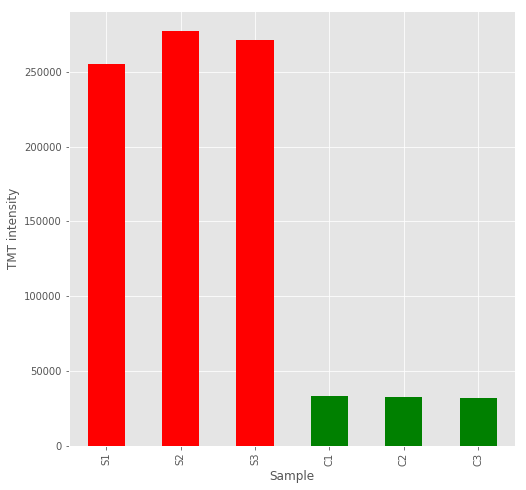

Interstitial collagenase;22 kDa interstitial collagenase;27 kDa interstitial collagenase


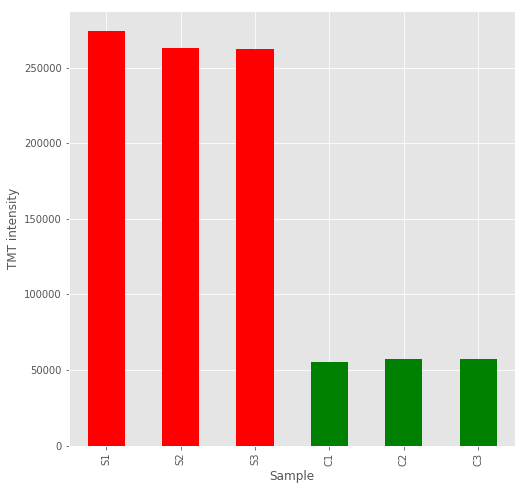

Nicotinamide phosphoribosyltransferase


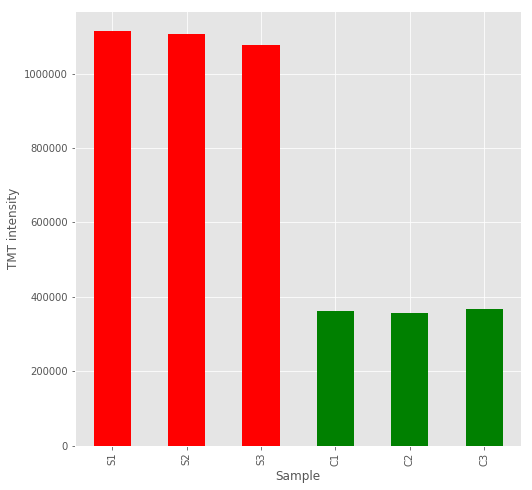

Tenascin


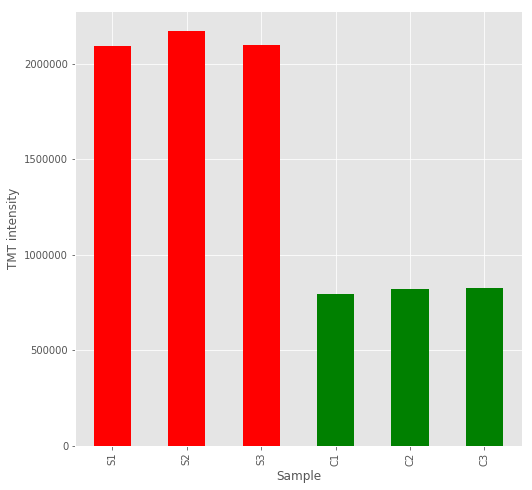

Uncharacterized protein C11orf96


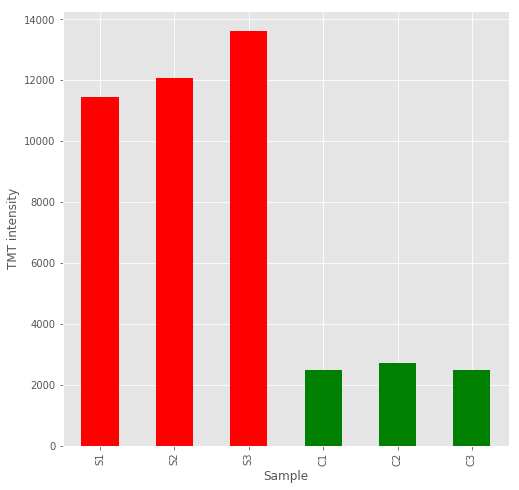

In [33]:
plot_prot(prot_id = 3555, data_def=data_def, df=df)  
plot_prot(prot_id = 2747, data_def=data_def, df=df) 
plot_prot(prot_id = 3380, data_def=data_def, df=df) 
plot_prot(prot_id = 3123, data_def=data_def, df=df) 
plot_prot(prot_id = 99, data_def=data_def, df=df) 



## Go term analysis
Ae select protein with a log2 fold change greather than 1 between Senescent and control
for go term analysis we will be using david online and visualize the outputs.

Also, if possible, we will select the uniprot-sprot ID between the ids of a protein group as the uniprot-sprot are likely to be better annotated.

In [32]:
skip = ['ITPI2_HUMAN','PAQR5_HUMAN']

def select_id(in_col):
    res = []
    for n in in_col:
        #print(n)
        temp = []
        item_list = n.split(';')
        for acc in item_list:
            #print (acc)
            if acc.count('|') >=2:
                temp_id = acc.split(' ')[0].split('|')[2]
                temp_type = acc.split(' ')[0].split('|')[0]
                #print (temp_type)
                if temp_type == 'sp' and temp_id:
                    temp.append(temp_id)
                    
                    break
        if len(temp) == 0:
            temp_id = item_list[0].split(' ')[0].split('|')[2]
            res.append(temp_id)
        else:
            res.append(temp[0])
    return res
             

df.columns
temp = df[['Protein IDs', 'Majority protein IDs', 'Peptide counts (all)',
       'Peptide counts (razor+unique)', 'Peptide counts (unique)',
       'Protein names', 'Gene names', 'Fasta headers', 'Number of proteins',
       'Peptides', 'Razor + unique peptides', 'Unique peptides', 'Sequence coverage [%]',
       'Unique + razor sequence coverage [%]', 'Unique sequence coverage [%]',
       'Mol. weight [kDa]', 'Sequence length', 'Sequence lengths',
        'Q-value','Score']]
temp.head()
selection=data_def.join(temp,how='left')
selection['david_input']=select_id(selection['Fasta headers'])
selection[selection['logFC']<-1].sort_values('FDR').to_csv('up_senescent_maxquant16660.csv')

### David Chart
This is an enrichment analysis for all the annotation keywords stored in the david database.
It is the most similar approch to the classical GO-term enrichment analysis. With david database, we have the benefit to test not only the go annotation but also several other controlled vocabulary annotation such as Panther, OMIM disease, uniprot keywords and so on

In [55]:
david_chart = pd.read_table('david\senescent_chart_E5E10F1F9FE11558598909804.txt')
david_chart.columns
genes = david_chart.Genes
del david_chart['Genes']
print(david_chart.shape)
david_chart[['Category','Term','Count','PValue']].head(30)

(277, 12)


,Category,Term,Count,PValue
0,GOTERM_CC_DIRECT,GO:0005615~extracellular space,39,7.795639e-14
1,UP_SEQ_FEATURE,signal peptide,52,6.694226e-10
2,UP_KEYWORDS,Secreted,38,1.178060e-09
3,UP_KEYWORDS,Signal,57,5.046490e-09
4,GOTERM_CC_DIRECT,GO:0005576~extracellular region,35,5.203820e-09
5,UP_KEYWORDS,Glycoprotein,59,1.787282e-08
6,UP_SEQ_FEATURE,disulfide bond,44,7.640002e-08
7,UP_KEYWORDS,Disulfide bond,48,1.087174e-07
8,GOTERM_BP_DIRECT,GO:0006954~inflammatory response,16,1.168337e-07
9,GOTERM_BP_DIRECT,GO:0030198~extracellular matrix organization,12,2.043422e-07


Those are the top 30 enriched terms. Several key words are clearly releted with senescence and re-organization of the extracellular matrix (extracellular space, signal peptide, inflammatory response, Rheumatoid arthritis

### David Cluster
Another peculiarity of david is to create cluster of similar keywords, that get togeter because they are releted to each other.

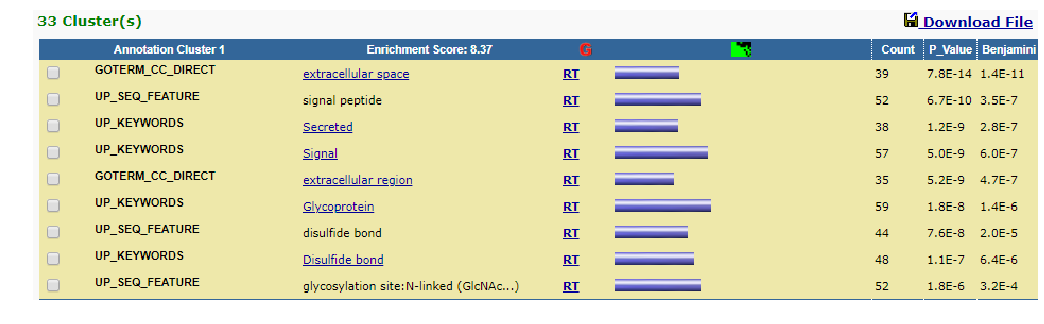

In [76]:
fig, ax = subplots(figsize=(18, 10))
img=mpimg.imread('david/Capture.PNG')
imgplot = ax.imshow(img)
plt.axis('off')
plt.grid(b=None)
plt.show()
#Image(filename='david/Capture.PNG') 

In [ ]:
# we use this cluster to get putative proteins that 

In [83]:
sprot_features = pd.read_table('uniprot_features.txt')

In [82]:
selection = selection.merge(sprot_features, left_on='david_input', right_on='yourlist')
selection.head()

,S1,S2,S3,C1,C2,C3,genes,ave_med,ave_exo,logFC,...,yourlist,Entry,Entry name,Protein names_y,Gene names_y,Organism,Length,Transmembrane,Transit peptide,Signal peptide
0,19957.365370,21385.348093,22934.889387,9231.138358,10166.741888,11769.244172,19_PPT2,21425.867617,10389.041473,-1.044291,...,G8JLL2_HUMAN,G8JLL2,G8JLL2_HUMAN,Lysosomal thioesterase PPT2 (Fragment),PPT2,Homo sapiens (Human),180,NaN,NaN,SIGNAL 1 27 {ECO:0000256|SAM:SignalP}.
1,22348.557417,22642.303778,21048.673034,8804.727932,9256.446305,8874.397651,59_FGF2,22013.178076,8978.523963,-1.293817,...,FGF2_HUMAN,P09038,FGF2_HUMAN,Fibroblast growth factor 2 (FGF-2) (Basic fibr...,FGF2 FGFB,Homo sapiens (Human),288,NaN,NaN,NaN
2,41512.939840,44192.015691,38495.001279,19198.468894,13236.551440,20962.681704,76_MYCBP,41399.985603,17799.234013,-1.217815,...,MYCBP_HUMAN,Q99417,MYCBP_HUMAN,c-Myc-binding protein (Associate of Myc 1) (AM...,MYCBP AMY1,Homo sapiens (Human),103,NaN,NaN,NaN
3,13120.948249,11930.153094,11274.013676,1149.023995,2144.249723,1909.150302,96_C11orf96,12108.371673,1734.141340,-2.803711,...,CK096_HUMAN,Q7Z7L8,CK096_HUMAN,Uncharacterized protein C11orf96 (Protein Ag2 ...,C11orf96 AG2,Homo sapiens (Human),435,NaN,NaN,NaN
4,32536.787259,39589.828736,40893.827424,7684.019021,9507.175686,9507.094837,116_SLC16A6,37673.481140,8899.429848,-2.081765,...,MOT7_HUMAN,O15403,MOT7_HUMAN,Monocarboxylate transporter 7 (MCT 7) (Monocar...,SLC16A6 MCT6 MCT7,Homo sapiens (Human),523,TRANSMEM 22 42 Helical. {ECO:0000255}.; TRANSM...,NaN,NaN


## Vulcano Plot with only selected proteins
we add transmembrane regions and signal peptide to add to the legend

In [86]:
selection.to_csv('def.csv')

In [154]:
selection = selection.replace(-np.inf,-4)
selection['log10p']=selection['log10p'].fillna(selection['log10p'].mean())
text_list = []
look_into = []

for n in selection.index.values:
    a=0
    text = selection['Protein names_y'].loc[n]
    text = text.split(' (')[0]
    text+='\n'
    #print (selection['Signal peptide'].loc[n])
    if str(selection['Signal peptide'].loc[n]) != 'nan':
        text+='has signal peptide\n'
        a=1
    if str(selection['Transmembrane'].loc[n]) != 'nan':
        text+='has Transmembrane\n'
        a=1
    if a >0:
        look_into.append(n)
    
    text_list.append(text)   

In [34]:
#interactive plot 'logFC',y='log10p'
trace_2 = go.Scatter(
    x=selection.logFC,
    y=selection.log10p,
    mode='markers',
    name='MA Plot',
    text = text_list,
    hoverinfo = 'text',
    marker=dict(
        #size=16,
        color = 'green'#np.log10(temp.Score), #set color equal to a variable
        #colorscale='Bluered',
        #showscale=True
    )
)

layout = dict(title='Vulcano, only selected',
             width=1000,
             height=800)


fig = go.Figure(data=[trace_2], 
                layout=layout)
iplot(fig, filename='test')

NameError: name 'text_list' is not defined

## Peptide Analysis

In [39]:
#load the datasetD:\michele\old_age\raw\combined\txt
df = pd.read_table(os.path.join('raw', 'combined', 'txt', 'peptides.txt'))
print(df.head())
#print(df.columns)
df = df[df['Potential contaminant']!='+']
df = df[df['Reverse']!='+']
#print(list(df.columns))
cols = ['Reporter intensity corrected {}'.format(n) for n in range(1,7)]
data=df[cols]
data.columns = ['S1','S2','S3', 'C1','C2','C3'] 
data.head()

                 Sequence          N-term cleavage window  \
0  AAAAAAAAAAAAAAAGAGAGAK  QSRFQVDLVSENAGRAAAAAAAAAAAAAAA   
1        AAAAAAAAAAGAAGGR  ______________________________   
2            AAAAAAAAAVSR  TTSSRVLRGGRDRGRAAAAAAAAAVSRRRK   
3          AAAAAAAAGAFAGR  GGGAGERAPLLGARRAAAAAAAAGAFAGRR   
4                AAAAAAAK  NSSLGAELSRKKKERAAAAAAAKMDGKESK   

           C-term cleavage window Amino acid before First amino acid  \
0  AAAAAAAAGAGAGAKQTPADGEASGESEPA                 R                A   
1  AAAAAAAAAGAAGGRGSGPGRRRHLVPGAG                 M                A   
2  RGRAAAAAAAAAVSRRRKAEYPRRRRSSPS                 R                A   
3  RAAAAAAAAGAFAGRRAACGAVLLTELLER                 R                A   
4  SRKKKERAAAAAAAKMDGKESKGSPVFLPR                 R                A   

  Second amino acid Second last amino acid Last amino acid Amino acid after  \
0                 A                      A               K                Q   
1                 A                      G

,S1,S2,S3,C1,C2,C3
0,16819.0,16794.0,14612.0,12487.0,15985.0,12510.0
1,2345.7,2503.8,2207.7,2579.2,4118.1,2545.5
2,3547.5,4032.6,3080.5,2165.4,3081.0,2463.1
3,6319.6,4295.7,3550.8,5158.7,5598.6,6103.7
4,4678.6,5015.3,4048.1,2664.7,3676.4,3146.6


(48080, 6)


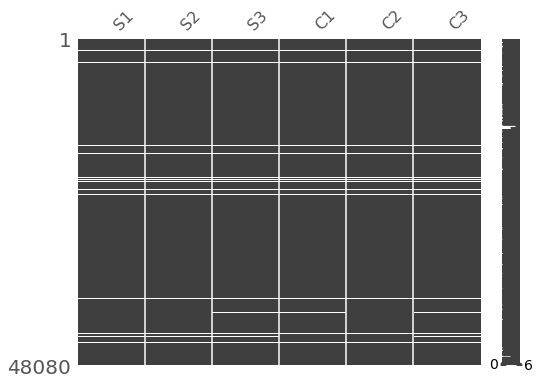

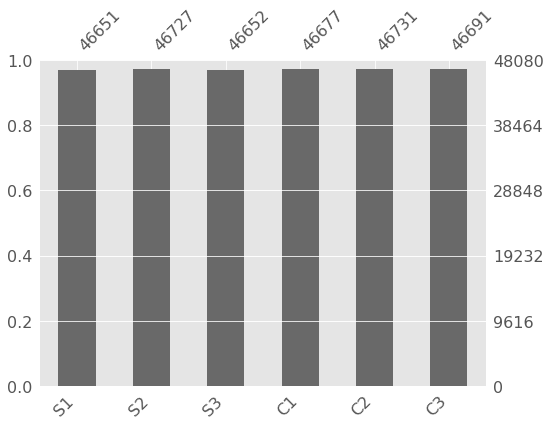

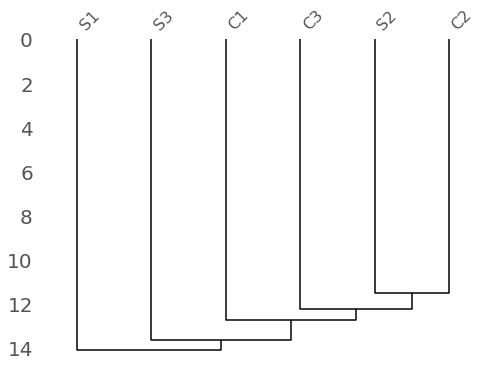

(48080, 6)


In [40]:
print(data.shape)
data=data.replace(0, np.nan)
msno.matrix(data, figsize=(8, 6))
#plt.title('Missing Data')
plt.show()

msno.bar(data, figsize=(8, 6))
plt.show()

msno.dendrogram(data, figsize=(8, 6))
plt.show()

data=data.replace(np.nan,0)
data = data.dropna(how='all')
print(data.shape)

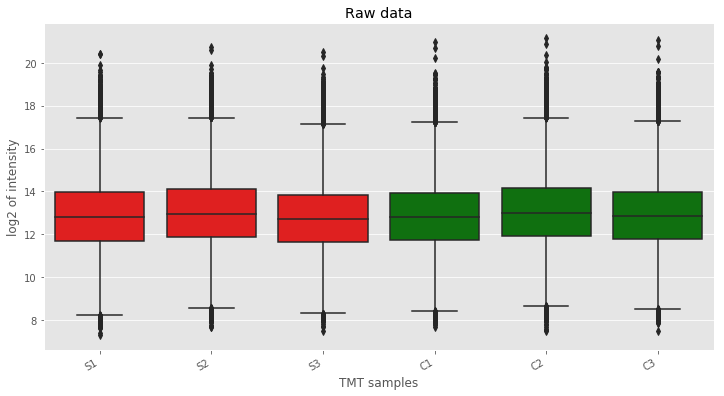

In [41]:
my_pal = ["r"]*3+["g"]*3
fig,ax=plt.subplots(figsize=(12,6))
g = sns.boxplot(data=np.log2(data),ax=ax,palette=my_pal)
g.set_xticklabels(data.columns, rotation=30, ha='right')
plt.title('Raw data')
plt.xlabel('TMT samples')
plt.ylabel('log2 of intensity')
plt.show()

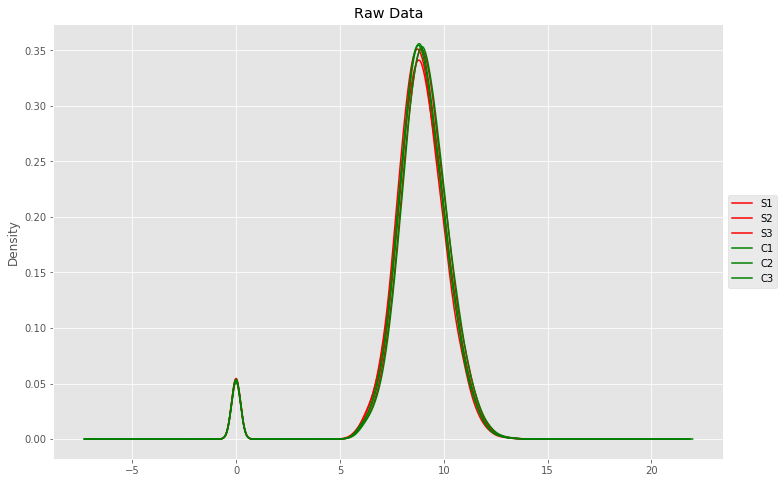

In [42]:
fig,ax=plt.subplots(figsize=(12,8))
np.log1p(data).plot(kind='kde',ax=ax,color=my_pal)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Raw Data')
plt.show()

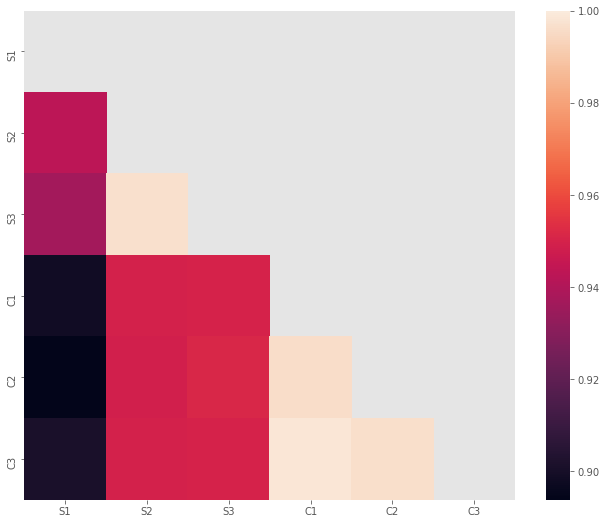

In [45]:
corr = data.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
#cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask )

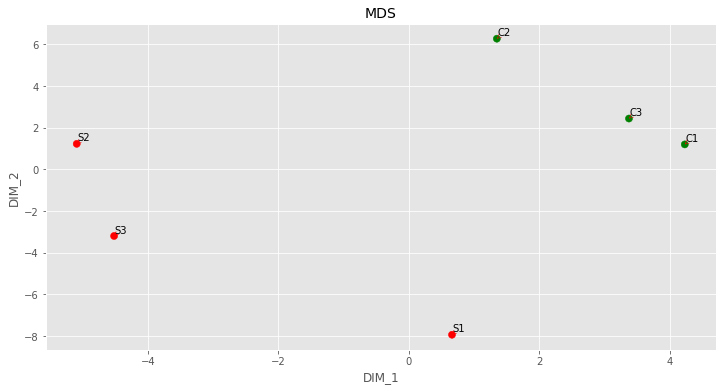

In [46]:
make_mds(np.log2(data), my_pal)

[0.86879437 0.0899042 ]


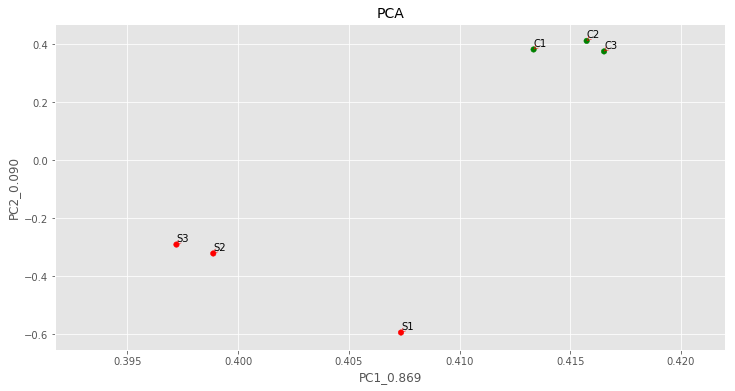

In [47]:
make_pca(np.log2(data), my_pal)

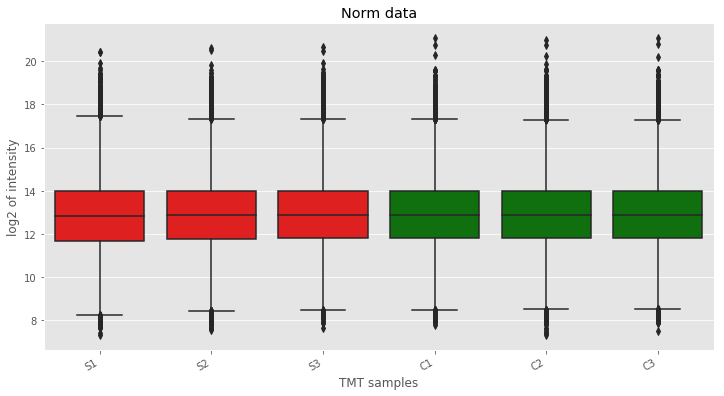

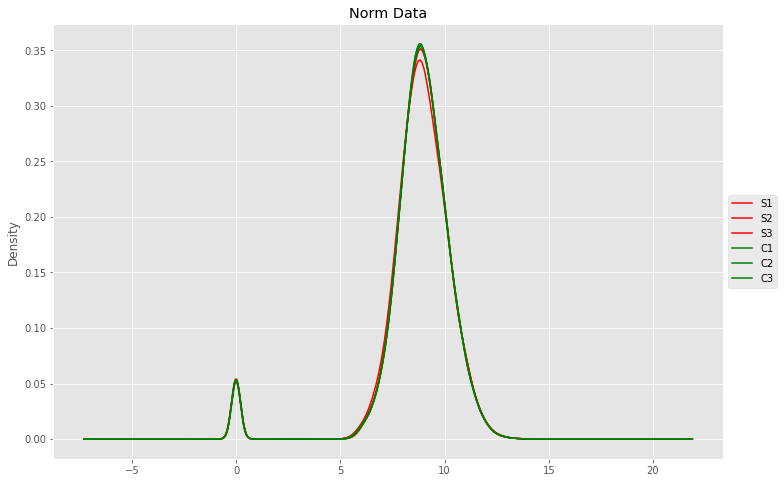

In [48]:
#normalization
#we create normalization factors based on the average sum intensity of each channel
col_sum = data.sum(axis=0)
target = np.mean(col_sum)
norm_facs = target / col_sum
data_norm = data.multiply(norm_facs, axis=1)


fig,ax=plt.subplots(figsize=(12,6))
g = sns.boxplot(data=np.log2(data_norm),ax=ax,palette=my_pal)
g.set_xticklabels(data.columns, rotation=30, ha='right')
plt.title('Norm data')
plt.xlabel('TMT samples')
plt.ylabel('log2 of intensity')
plt.show()
fig,ax=plt.subplots(figsize=(12,8))
np.log1p(data_norm).plot(kind='kde',ax=ax,color=my_pal)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Norm Data')
plt.show()

In [50]:
data_norm.shape

(48080, 6)

In [51]:
df.head()

,Sequence,N-term cleavage window,C-term cleavage window,Amino acid before,First amino acid,Second amino acid,Second last amino acid,Last amino acid,Amino acid after,A Count,...,Reverse,Potential contaminant,id,Protein group IDs,Mod. peptide IDs,Evidence IDs,MS/MS IDs,Best MS/MS,Oxidation (M) site IDs,MS/MS Count
0,AAAAAAAAAAAAAAAGAGAGAK,QSRFQVDLVSENAGRAAAAAAAAAAAAAAA,AAAAAAAAGAGAGAKQTPADGEASGESEPA,R,A,A,A,K,Q,18,...,NaN,NaN,0,3598,0,0;1;2;3,0;1;2;3,1.0,NaN,4
1,AAAAAAAAAAGAAGGR,______________________________,AAAAAAAAAGAAGGRGSGPGRRRHLVPGAG,M,A,A,G,R,G,12,...,NaN,NaN,1,4807,1,4,4,4.0,NaN,1
2,AAAAAAAAAVSR,TTSSRVLRGGRDRGRAAAAAAAAAVSRRRK,RGRAAAAAAAAAVSRRRKAEYPRRRRSSPS,R,A,A,S,R,R,9,...,NaN,NaN,2,340,2,5,5,5.0,NaN,1
3,AAAAAAAAGAFAGR,GGGAGERAPLLGARRAAAAAAAAGAFAGRR,RAAAAAAAAGAFAGRRAACGAVLLTELLER,R,A,A,G,R,R,10,...,NaN,NaN,3,5014,3,6,6,6.0,NaN,1
4,AAAAAAAK,NSSLGAELSRKKKERAAAAAAAKMDGKESK,SRKKKERAAAAAAAKMDGKESKGSPVFLPR,R,A,A,A,K,M,7,...,NaN,NaN,4,6240,4,7,7,7.0,NaN,1


In [55]:
temp = df[['Gene names','Sequence']]
temp['genes']=[str(n).split(';')[0] for n in temp['Gene names']]
temp['genes']=[str(n[0])+'_'+str(n[1]) for n in zip(temp['Sequence'],temp['genes'])]
data_norm['genes']=data_norm.index.map(temp['genes'])
data_norm.head()

,S1,S2,S3,C1,C2,C3,genes
0,16998.515286,15579.667046,16380.645728,13195.168403,14432.977774,12678.309893,AAAAAAAAAAAAAAAGAGAGAK_SLC12A2
1,2370.736507,2322.756362,2474.921405,2725.472759,3718.263733,2579.747229,AAAAAAAAAAGAAGGR_PABPN1
2,3585.363754,3741.012584,3453.365670,2288.205146,2781.858275,2496.238617,AAAAAAAAAVSR_ZFP91
3,6387.051383,3985.088468,3980.591079,5451.262532,5055.018415,6185.819352,AAAAAAAAGAFAGR_SLC15A4
4,4728.536394,4652.655957,4538.084586,2815.821674,3319.449452,3188.934445,AAAAAAAK_CDK12


In [56]:
data_norm['genes']=[str(n[0])+'_'+str(n[1]) for n in zip(data_norm.index.values,data_norm['genes'])]
data_norm.to_csv('norm_data_pep_maxquant16660.csv',sep='\t',index=False)

In [57]:
data_norm.head()

,S1,S2,S3,C1,C2,C3,genes
0,16998.515286,15579.667046,16380.645728,13195.168403,14432.977774,12678.309893,0_AAAAAAAAAAAAAAAGAGAGAK_SLC12A2
1,2370.736507,2322.756362,2474.921405,2725.472759,3718.263733,2579.747229,1_AAAAAAAAAAGAAGGR_PABPN1
2,3585.363754,3741.012584,3453.365670,2288.205146,2781.858275,2496.238617,2_AAAAAAAAAVSR_ZFP91
3,6387.051383,3985.088468,3980.591079,5451.262532,5055.018415,6185.819352,3_AAAAAAAAGAFAGR_SLC15A4
4,4728.536394,4652.655957,4538.084586,2815.821674,3319.449452,3188.934445,4_AAAAAAAK_CDK12


In [3]:
options(warn=-1)
library("tidyverse")
library("psych")
library("gridExtra")
library("scales")
library("limma") 
library("edgeR") 
MQ_tmt <- read_tsv("norm_data_pep_maxquant16660.csv")
accession <- MQ_tmt$'genes'
MQ_tmt = within(MQ_tmt, rm('genes'))
head(MQ_tmt)

Parsed with column specification:
cols(
  S1 = col_double(),
  S2 = col_double(),
  S3 = col_double(),
  C1 = col_double(),
  C2 = col_double(),
  C3 = col_double(),
  genes = col_character()
)


S1,S2,S3,C1,C2,C3
16998.515,15579.667,16380.646,13195.168,14432.978,12678.310
2370.737,2322.756,2474.921,2725.473,3718.264,2579.747
3585.364,3741.013,3453.366,2288.205,2781.858,2496.239
6387.051,3985.088,3980.591,5451.263,5055.018,6185.819
4728.536,4652.656,4538.085,2815.822,3319.449,3188.934
68083.000,65038.662,66679.497,58209.005,54165.426,60524.488


In [4]:
head(MQ_tmt)
group <- factor(c(1,1,1,2,2,2))
design <- model.matrix(~group)
y <- DGEList(counts = MQ_tmt, group = group, genes = accession)
y <- estimateDisp(y, design)
fit <- glmQLFit(y, design)
tr <- glmTreat(fit, coef=2, lfc=1.3)
topTags(tr)

S1,S2,S3,C1,C2,C3
16998.515,15579.667,16380.646,13195.168,14432.978,12678.310
2370.737,2322.756,2474.921,2725.473,3718.264,2579.747
3585.364,3741.013,3453.366,2288.205,2781.858,2496.239
6387.051,3985.088,3980.591,5451.263,5055.018,6185.819
4728.536,4652.656,4538.085,2815.822,3319.449,3188.934
68083.000,65038.662,66679.497,58209.005,54165.426,60524.488


,genes,logFC,unshrunk.logFC,logCPM,PValue,FDR
36141,36717_SFLYSAAK_STC1,-3.160085,-3.160091,7.542407,1.064224e-09,5.116787e-05
16389,16657_IAAYGHEVGK_KYNU,-2.816758,-2.816797,4.401826,2.134843e-08,2.969516e-04
3270,3323_ASLAFLQK_PLA2G7,2.705434,2.705460,4.822717,2.523328e-08,2.969516e-04
25557,25961_LKFDPELLFNK_PTGS2,-3.635820,-3.635874,4.753688,2.929058e-08,2.969516e-04
8234,8370_ELANILK_TGFBI,-2.411005,-2.411011,6.614098,3.088099e-08,2.969516e-04
9970,10136_FDILCVVR_MCM2,2.870528,2.870642,2.913786,4.480724e-08,3.264445e-04
6850,6966_DWVGIFK_TAX1BP1,2.982302,2.982312,6.528331,4.987047e-08,3.264445e-04
12404,12608_GAVYGGFK_HEL-S-117,3.052735,3.052757,5.436873,5.849685e-08,3.264445e-04
15183,15438_GWNYILEK_NAMPT,-2.214026,-2.214031,6.773826,6.938821e-08,3.264445e-04
46481,47211_YEDLLTR_GDF15,-2.592887,-2.592908,5.105258,7.437482e-08,3.264445e-04


In [10]:
tt <- topTags(tr, n = Inf, sort.by = "PValue")$table
head(tt)
write.table(tt,'limma_data_pep_maxquant16660.txt')

,genes,logFC,unshrunk.logFC,logCPM,PValue,FDR
36141,36717_SFLYSAAK_STC1,-3.160085,-3.160091,7.542407,1.064224e-09,5.116787e-05
16389,16657_IAAYGHEVGK_KYNU,-2.816758,-2.816797,4.401826,2.134843e-08,2.969516e-04
3270,3323_ASLAFLQK_PLA2G7,2.705434,2.705460,4.822717,2.523328e-08,2.969516e-04
25557,25961_LKFDPELLFNK_PTGS2,-3.635820,-3.635874,4.753688,2.929058e-08,2.969516e-04
8234,8370_ELANILK_TGFBI,-2.411005,-2.411011,6.614098,3.088099e-08,2.969516e-04
9970,10136_FDILCVVR_MCM2,2.870528,2.870642,2.913786,4.480724e-08,3.264445e-04


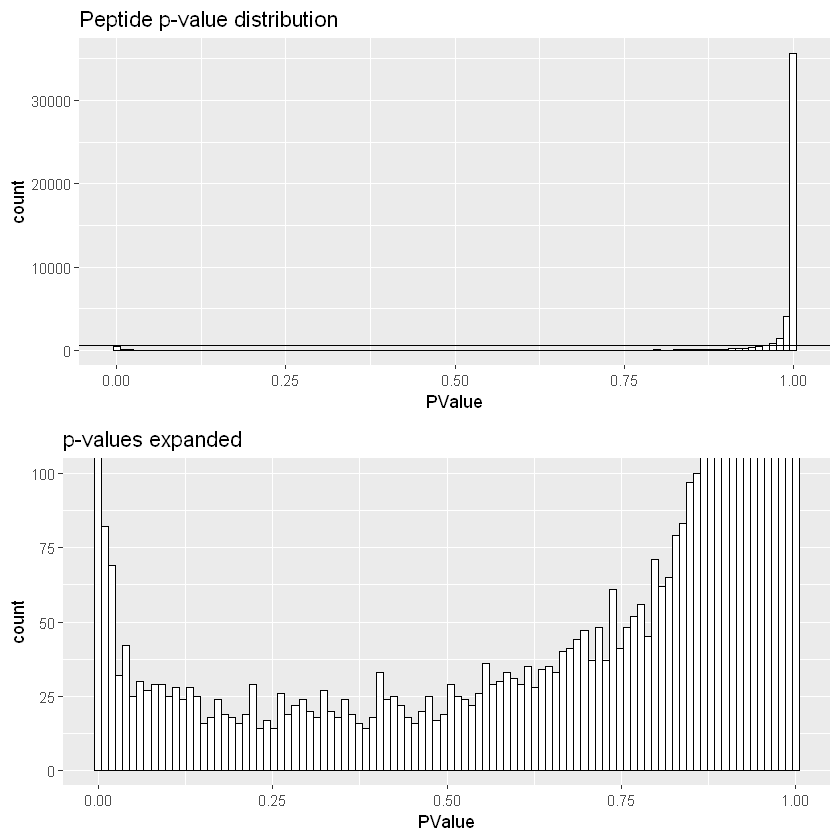

In [8]:
pvalue_plots <- function(results, ylim, title) {
    # Makes p-value distribution plots
        # results - results data frame
        # ylim - ymax for expanded view
        # title - plot title
    p_plot <- ggplot(results, aes(PValue)) + 
        geom_histogram(bins = 100, fill = "white", color = "black") +
        geom_hline(yintercept = mean(hist(results$PValue, breaks = 100, 
                                     plot = FALSE)$counts[26:100]))

    # we will need an expanded plot
    p1 <- p_plot + ggtitle(str_c(title, " p-value distribution"))
    p2 <- p_plot + coord_cartesian(xlim = c(0, 1.0), ylim = c(0, ylim)) + 
        ggtitle("p-values expanded")
    grid.arrange(p1, p2, nrow = 2) # from gridExtra package
}

pvalue_plots(tt, 100, "Peptide")

In [11]:
limma_data <- read_tsv("norm_data_pep_maxquant16660.csv")
accession <- limma_data$'genes'
limma_data = within(limma_data, rm('genes'))
head(limma_data)
row.names(limma_data) <- accession # add accessions as row names
# set up the design matrix
group <- as.factor(c(rep("senescent", 3), rep("control", 3)))
group <- factor(group, levels(group)[c(2, 1)]) # set the factor order
design <- model.matrix(~ 0 + group)
colnames(design) <- c("senescent", "control")
design
# make the contrast
contrast <- makeContrasts(senescent-control, levels = design)
contrast

S <- 1:3
C <- 4:6
# do the linear model fitting on log2 values
limma_log_data <- log2(limma_data[c(S, C)])
fit <- lmFit(limma_log_data, design)

# get the fit for the contrast of interest
fit2 <- contrasts.fit(fit, contrast)

# do the empirical Bayes moderation of the test statistic (with trended variance)
fit2 <- eBayes(fit2, trend = TRUE)

# grab the information in topTable so we can get the data to plot candidates
# the coef parameter has to do with the contrast of interest
# specify no sorting of results and a number that is longer than the data table
tt_limma <- topTable(fit2, coef = 1, sort.by = "none", number = Inf)

# let's see how many up and down candidates, and the top tags
summary(decideTests(fit2, p.value = 0.10))
topTable(fit2)
limma_data$ave_med <- rowMeans(limma_data[S])
limma_data$ave_exo  <- rowMeans(limma_data[C])
limma_data$logFC <- log2(limma_data$ave_exo / limma_data$ave_med)
limma_data$FC <- ifelse(limma_data$ave_exo > limma_data$ave_med, 
                          (limma_data$ave_exo / limma_data$ave_med), 
                          (-1 * limma_data$ave_med / limma_data$ave_exo))
limma_data$Acc <- accession
head(limma_data)

Parsed with column specification:
cols(
  S1 = col_double(),
  S2 = col_double(),
  S3 = col_double(),
  C1 = col_double(),
  C2 = col_double(),
  C3 = col_double(),
  genes = col_character()
)


S1,S2,S3,C1,C2,C3
16998.515,15579.667,16380.646,13195.168,14432.978,12678.310
2370.737,2322.756,2474.921,2725.473,3718.264,2579.747
3585.364,3741.013,3453.366,2288.205,2781.858,2496.239
6387.051,3985.088,3980.591,5451.263,5055.018,6185.819
4728.536,4652.656,4538.085,2815.822,3319.449,3188.934
68083.000,65038.662,66679.497,58209.005,54165.426,60524.488


senescent,control
1,0
1,0
1,0
0,1
0,1
0,1


,senescent - control
senescent,1
control,-1


       senescent - control
Down                  9231
NotSig               29226
Up                    8318

,logFC,AveExpr,t,P.Value,adj.P.Val,B
36141,3.159396,16.37077,55.26858,9.030774e-11,4.224145e-06,14.25396
8234,2.410568,15.72151,42.16518,6.363275e-10,7.420766e-06,13.05765
15183,2.213373,15.94687,40.74791,8.141689e-10,7.420766e-06,12.88584
3270,-2.704669,13.82540,-38.70490,1.179478e-09,7.420766e-06,12.61901
44237,-2.174743,14.95146,-37.76233,1.408704e-09,7.420766e-06,12.48764
16389,2.815900,13.36302,37.17284,1.577731e-09,7.420766e-06,12.40266
43246,2.142290,16.04121,36.77364,1.705301e-09,7.420766e-06,12.34382
9519,-2.034280,14.90381,-36.48938,1.803302e-09,7.420766e-06,12.30128
12752,2.052107,14.63844,35.56411,2.169586e-09,7.420766e-06,12.15895
41260,2.524260,14.21353,35.54715,2.177046e-09,7.420766e-06,12.15629


S1,S2,S3,C1,C2,C3,ave_med,ave_exo,logFC,FC,Acc
16998.515,15579.667,16380.646,13195.168,14432.978,12678.310,16319.609,13435.485,-0.2805581,-1.214665,0_AAAAAAAAAAAAAAAGAGAGAK_SLC12A2
2370.737,2322.756,2474.921,2725.473,3718.264,2579.747,2389.471,3007.828,0.3320305,1.258784,1_AAAAAAAAAAGAAGGR_PABPN1
3585.364,3741.013,3453.366,2288.205,2781.858,2496.239,3593.247,2522.101,-0.5106624,-1.424704,2_AAAAAAAAAVSR_ZFP91
6387.051,3985.088,3980.591,5451.263,5055.018,6185.819,4784.244,5564.033,0.2178402,1.162991,3_AAAAAAAAGAFAGR_SLC15A4
4728.536,4652.656,4538.085,2815.822,3319.449,3188.934,4639.759,3108.069,-0.5780316,-1.492811,4_AAAAAAAK_CDK12
68083.000,65038.662,66679.497,58209.005,54165.426,60524.488,66600.387,57632.973,-0.2086361,-1.155595,5_AAAAAAALQAK_RPL4


In [16]:
# statisticl test results
limma_data$PValue <- tt_limma$P.Value
limma_data$FDR <- tt_limma$adj.P.Val
head(limma_data)
# add a DE candidate status column
limma_data$candidate <- cut(limma_data$FDR, breaks = c(-Inf, 0.01, 0.05, 0.10, 1.0), 
                           labels = c("high", "med", "low", "no"))
pvalue_plots(limma_data, "test")

S1,S2,S3,C1,C2,C3,ave_med,ave_exo,logFC,FC,Acc,PValue,FDR
16998.515,15579.667,16380.646,13195.168,14432.978,12678.310,16319.609,13435.485,-0.2805581,-1.214665,0_AAAAAAAAAAAAAAAGAGAGAK_SLC12A2,0.0074562854,0.030658206
2370.737,2322.756,2474.921,2725.473,3718.264,2579.747,2389.471,3007.828,0.3320305,1.258784,1_AAAAAAAAAAGAAGGR_PABPN1,0.0896298599,0.188113750
3585.364,3741.013,3453.366,2288.205,2781.858,2496.239,3593.247,2522.101,-0.5106624,-1.424704,2_AAAAAAAAAVSR_ZFP91,0.0030032643,0.016072962
6387.051,3985.088,3980.591,5451.263,5055.018,6185.819,4784.244,5564.033,0.2178402,1.162991,3_AAAAAAAAGAFAGR_SLC15A4,0.2461548086,0.386800523
4728.536,4652.656,4538.085,2815.822,3319.449,3188.934,4639.759,3108.069,-0.5780316,-1.492811,4_AAAAAAAK_CDK12,0.0008216778,0.006415286
68083.000,65038.662,66679.497,58209.005,54165.426,60524.488,66600.387,57632.973,-0.2086361,-1.155595,5_AAAAAAALQAK_RPL4,0.0090006645,0.035158824


ERROR: Error in str_c(title, " p-value distribution"): argument "title" is missing, with no default
